# XGBoost models informed by feature selection analysis (using 1 k-fold)
## Binary model predicting patient is at least as well as mRS0, mRS1, mRS2. mRS3. mRS4 and mRS5.

### Plain English summary

To look at the interaction of feature Year with Stroke team (as year is only selected in the feature list if stroke team an option too).

SHAP interactions can not be calculated for multiclass classification. Instead train binary models, converting the target feature (disability_discharge) into a binary feature by predicting one class vs the rest. Have seven models (predict mRS0 vs mRS1-6, predict mRS1 vs rest, predict mRS2 vs rest, predict mRS3 vs rest, predict mRS4 vs rest, predict mRS5 vs rest, predict mRS6 vs mRS0-5)  

Use just first kfold as seen performance of model is consistent across the 5 kfold splits.

Each binary model is trained using 7 features "prior_disability", "stroke_severity", "stroke_team", "age", "onset-to-thrombolysis-time", "any_afib_diagnosis", "precise_onset_known"]\

### Model and data

Set of 6 binary XGBoost classification models, predicting whether a single mRS, or not.\
7 features: ["prior_disability", "stroke_severity", "stroke_team", "age", "onset-to-thrombolysis-time", "any_afib_diagnosis", "precise_onset_known"]\
First k-fold\

### Aims


### Observations




#### Further work

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb




## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

import scipy

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import pickle
import shap

from os.path import exists

import math

import copy

import time
import datetime

Report the time duration to run notebook

In [2]:
start_time = time.time()

Use just the first k-fold split

In [3]:
k = 1
target_feature = 'discharge_disability'
n_binary_models = 6

Select the features for the model

In [4]:
x_selected_features = ["prior_disability", "stroke_severity", "stroke_team", 
                       "age", "any_afib_diagnosis", 
                       "onset_to_thrombolysis_time", "precise_onset_time"]
n_features = len(x_selected_features)

## Set up paths and filenames

For consistency, the folders end with "/" and the text for filenames include no trailing "_".

In [5]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    output_save_path: str = './output/'
    model_save_path: str = './saved_models/'
    data_read_path: str = '../data/kfold_5fold/'
    model_text: str = (f'xgb_{n_features}_features_1kfold'
                       f'_binary')
    notebook: str = '080'

paths = Paths()

Create output folders if needed

In [6]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Import the first kfold split

In [10]:
train_data = pd.read_csv(paths.data_read_path + '03_train_{0}.csv'.format(k))
test_data = pd.read_csv(paths.data_read_path + '03_test_{0}.csv'.format(k))

In [ ]:
def convert_feature_to_binary(df, target_feature, binary_threshold):
    """
    
    Args:
        df []:
        target_feature []:
        binary_threshold []:
        
    Return:
        df []:
    
    """
    df[f'binary_{binary_threshold}'] = 0
    df[f'binary_{binary_threshold}'] = (df[target_feature] <= binary_threshold) * 1
    df.drop([target_feature],axis=1,inplace=True)
    return(df)

In [ ]:
def setup_binary_feature(binary_threshold, x_selected_features):
    """
    
    Args:
        binary_threshold []:
        x_selected_features []:
        
    Return:
        dict []:
    
    """    
    dict = {}
    dict["binary_target_feature"] = f'binary_{binary_threshold}'
    dict["selected_features"] = x_selected_features.append(dict["binary_target_feature"])
    return(dict)

Show the proportion of patients in each binary category, for each threshold level

In [ ]:
def calculate_proportion_binary_split():
    """
    
    Args:
        
    Return:
        count_0 []: 
        count_1 []:
    
    """  
    count_0 = []
    count_1 = []
    for b in range(6):
        df = test_data.copy(deep=True)
        complete_data_binary = convert_feature_to_binary(df, target_feature, b)
        count_0.append((complete_data_binary[f'binary_{b}'] == 0).sum())
        count_1.append((complete_data_binary[f'binary_{b}'] == 1).sum())
    return(count_0, count_1)

Plot barchart

In [ ]:
def plot_barchart(count_0, count_1):
    """
    
    Args:
        count_0 []: 
        count_1 []:
        
    Return:
        None    
    """  
    
    # create data
    x = np.arange(len(count_1)).tolist()
    
    # plot bars in stack manner
    plt.bar(x, count_1, bottom=count_0, color='b', label="Yes")
    plt.bar(x, count_0, color='r', label="No")
    plt.xlabel("mRS threshold for being 'at least as well as'")
    plt.ylabel("Count of patients")
    plt.legend(bbox_to_anchor=(1.03, 1.0))
    plt.title("Count of patients in each binary category, for each threshold level (test dataset)")
    plt.show()
    return()

Prepare the datasets for this binary threshold level

In [ ]:
def prepare_datasets(train_data, target_feature, binary_threshold, selected_features):

    """
    
    Args:
        train_data []:
        target_feature []:
        binary_threshold []:
        selected_features []:
        
    Return:
        train_data []:
        test_data []:
        
    """  

    train_data = convert_feature_to_binary(train_data, target_feature, 
                                           binary_threshold)
    train_data = train_data[selected_features]

    test_data = convert_feature_to_binary(test_data, target_feature, 
                                          binary_threshold)
    test_data = test_data[selected_features]
    return(train_data, test_data)

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [ ]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Create function to return X and y data for train and test sets

In [ ]:
def get_x_y_data(train, test, target):
    """
    Pass data from the split and return the dataframes with the target in one 
    dataframe (X), and dependent features in another (y)
    
    Args:
        train [dataframe]: dataframe containing training instances 
        test [dataframe]: dataframe containing test instances
        target [string]: column name of the targert feature (the column to separate 
                        from the two dataframes)

    Returns:
        X_train [dataframe]: dataframe containing input features for the 
                            training instances 
        X_test [dataframe]: dataframe containing target feature for the training 
                            instances 
        y_train [dataframe]: dataframe containing input features for the 
                             training instances 
        y_test [dataframe]: dataframe containing target features for the 
                            training instances 
    """   

    # Get X and y
    X_train = train.drop(target, axis=1)
    X_test = test.drop(target, axis=1)
    y_train = train[target]
    y_test = test[target]

    return(X_train, X_test, y_train, y_test)

Define function to fit XGBoost model

In [ ]:
def fit_xgb_model(X_train, y_train, filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train a new model.

    Args:
        filename [string]: where xgboost model is saved
        X_train [dataframe]: feature values
        y_train [dataframe]: target feature
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Define and Fit model
        model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5,
                                tree_method='gpu_hist')
        model.fit(X_train, y_train)

        with open(filename, 'wb') as filehandler:
            pickle.dump(model, filehandler)

    return(model)

Define function to calculate preditions from model

In [ ]:
def calculate_predicted_probabilities(model, X_data):
    """ 
    Given a model and input data, return the models probability and prediction
    for each instance.
    
    Args:
        model [xgboost classifier object]: trained model
        X_data [dataframe]: input features for model

    Return:
        y_probs [array]: the probability of being in each target feature class
        y_pred [array]: the prediction (the class with the largest probability)
    """

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_data)

    # Get and store predicted class
    y_pred = model.predict(X_data)

    return(y_probs, y_pred)

Code to setup data per binary threshold, fit model and analyse performance

In [ ]:
y_test_binary = []
y_pred_binary = []

# Include the new binary feature we calculate (replaces the multiclass feature)
for binary_threshold in range(n_binary_models):
    print(f"Model using binary threshold {binary_threshold}")
    dict_binary = setup_binary_feature(binary_threshold, x_selected_features)

    (count_0, count_1) = calculate_proportion_binary_split(
                            test_data, dict_binary["binary_target_feature"])
    plot_barchart(count_0, count_1)
    (train_data, test_data) = prepare_datasets(
                                        train_data, target_feature, 
                                        binary_threshold, x_selected_features)
    #Keep copy of original test data, with 'Stroke team' not one-hot encoded
    test_data_orig = test_data.copy(deep=True)
    train_data_orig = train_data.copy(deep=True)

    feature = "stroke_team"
    prefix = "team_"
    if feature in list(train_data):
        train_data = convert_feature_to_one_hot(train_data, feature, prefix)
        test_data = convert_feature_to_one_hot(test_data, feature, prefix)

    feature_names_ohe = list(train_data)
    feature_names_ohe.remove(dict_binary["binary_target_feature"])
    n_features = len(feature_names_ohe)


    # Get k fold split (this notebook is only using kfold split 0)
    (X_train, X_test, y_train, y_test) = get_x_y_data(
                                train_data,
                                test_data,
                                dict_binary["binary_target_feature"])
    y_test_binary.append(y_test)

    # Model filename
    filename = os.path.join(paths.model_save_path, 
                            (paths.notebook + '_' + paths.model_text + 
                             binary_threshold + '.p'))

    ## Fit XGBoost model
    model = fit_xgb_model(X_train, y_train, filename)

    (y_probs, y_pred) = calculate_predicted_probabilities(model, X_test)
    y_pred_binary.append(y_pred)
    
    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test, y_probs[:,1], labels = model.classes_, 
                                multi_class = 'ovr', average = 'macro')

    # Get ROC AUC
    fpr, tpr, thresholds = roc_curve(y_test, y_probs[:,1])
    roc_auc = auc(fpr, tpr)

    # Calculate error
    y_error = y_test - y_pred
    accuracy = np.mean(y_error==0)

    # Get and store feature importances
    feature_importance = model.feature_importances_

    print (f'Accuracy: {accuracy:0.3f} ')
    print (f'ROCAUC: {roc_auc:0.3f}')
    print()

Get list of features

In [14]:
features = list(train_data)
print(f"There are {len(features)} original features (before one-hot encoding)")

There are 8 original features (before one-hot encoding)


For each feature in the list, for each train and test dataset, convert to one hot encoded.

Feature names with one hot encoding

In [19]:
features_ohe = list(train_data)
features_ohe.remove(binary_target_feature)
n_features = len(features_ohe)

print(f"There are {n_features} features (after one-hot encoding)")

There are 124 features (after one-hot encoding)


Confusion matrix for each model using binary threshold

Resource (subplots with imshow): https://stackoverflow.com/questions/18266642/multiple-imshow-subplots-each-with-colorbar

In [ ]:
# Define number subplots for the figure
nrows = 1
ncols = n_binary_models

fig, axs = plt.subplots(nrows=nrows, ncols=ncols)

if ncols > 1:
    fig.suptitle('Confusion matrices (per binary threshold model)', fontsize=10)

# Set figure size
fig.set_size_inches(24,5)

# Legend height
shrink = 0.5

# Initialise indices for the subplots
row = 0
col = 0

# Loop through the kfolds, create a subplot per kfold (of a confusion matrix)
for t, ax in zip(range(n_binary_models), axs):

#    # Get axes
#    if col > 1:
#        # not take row argument as that only has 1 value, so axs is 1D
#        ax = axs[col] 
#    else:
#        ax = axs

    # Set axis title
    ax.set_title(f'Binary threshold {t+1}')

    # Calculate values for confusion matrix
    cm = confusion_matrix(y_test_binary[t], y_pred_binary[t])

    # Visualize the confusion matrix with colors
    heatmap = ax.imshow(cm, cmap=plt.cm.Blues, origin='lower')
    plt.colorbar(heatmap, shrink=shrink, ax=ax, alpha=0.5, label='Count')

    # Add values to plot
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            ax.text(j, i, cm[i][j], ha='center', va='center', color='grey', 
                    size=8)

    # Set axis titles
    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Observed value')

    # Move to the next subplot
    col += 1
    # Move to the next row if exceed number of columns
    if col == ncols: 
        col = 0
        row += 1

plt.tight_layout()

# Make space for title
plt.subplots_adjust(top=1)

filename = os.path.join(paths.output_save_path, 
                        (paths.notebook + paths.model_text + 
                       '_confusion_matrices_per_binary_threshold.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

## Identify intersection of sensitivity and specificity

In [25]:

def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate: Same as specificity
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

Calculate data for sensitivity-specificity curve:

In [26]:
# Set up list for accuracy measures
sensitivity = []
specificity = []

# Loop through increments in probability of survival
thresholds = np.arange(0.0, 1.01, 0.01)
for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
    # Get classificiation using cutoff
    predicted_class = y_probs[:,1] >= cutoff
    predicted_class = predicted_class * 1.0
    # Call accuracy measures function
    accuracy = calculate_accuracy(y_test, predicted_class)
    # Add accuracy scores to lists
    sensitivity.append(accuracy['sensitivity'])
    specificity.append(accuracy['specificity'])

Create a combined plot: ROC and sensitivity-specificity

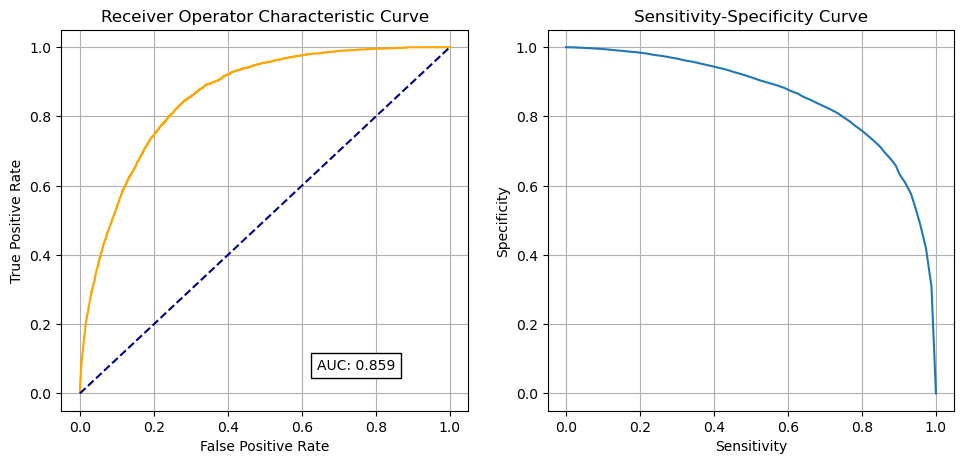

In [27]:
fig = plt.figure(figsize=(10,5))

# Plot ROC
ax1 = fig.add_subplot(121)
ax1.plot(fpr, tpr, color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'AUC: {roc_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)

# Plot sensitivity-specificity
ax2 = fig.add_subplot(122)
ax2.plot(sensitivity, specificity)
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Specificity')
ax2.set_title('Sensitivity-Specificity Curve')
plt.grid(True)


plt.tight_layout(pad=2)
plt.savefig(f'./{paths.output_save_path}{paths.notebook}_{paths.model_text}'
            '_roc_sens_spec.jpg', dpi=300)

plt.show()

# Identify cross-over point on sensitivity-specificity curve
Adjusting the classification threshold allows us to balance sensitivity (the proportion of patients receiving thrombolysis correctly identified) and specificity (the proportion of patients not receiving thrombolysis correctly identified). An increase in sensitivity causes a loss in specificity (and vice versa). Here we identify the pint where specificity and sensitivity hold the same value.

In [28]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and 
    b2,b1.
    
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

In [29]:
df = pd.DataFrame()
df['sensitivity'] = np.array(sensitivity)
df['specificity'] = np.array(specificity)
df['spec greater sens'] = df['specificity'] > df['sensitivity']

# find last index for senitivity being greater than specificity 
mask = df['spec greater sens'] == False
last_id_sens_greater_spec = np.max(df[mask].index)
locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
points = df.iloc[locs][['sensitivity', 'specificity']]

# Get intersetction with line of x=y
a1 = list(points.iloc[0].values)
a2 = list(points.iloc[1].values)
b1 = [0, 0]
b2 = [1, 1]

intersection = get_intersect(a1, a2, b1, b2)[0]

print (f'Intersection: {intersection:0.4f}')

Intersection: 0.7771


### SHAP values
SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios. A SHAP value is returned for each feature, for each instance, for each model (one per k-fold)

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees. Using this we can calculate the SHAP values.

Either load from pickle (if file exists), or calculate.

In [30]:
# Set filename

filename = os.path.join(paths.output_save_path, 
                        (paths.notebook + paths.model_text + binary_threshold + 
                         '_shap_values_extended.p'))

# Check if exists
file_exists = exists(filename)

if file_exists:
    # Load explainer
    with open(filename, 'rb') as filehandler:
        shap_values_extended = pickle.load(filehandler)
        shap_values = shap_values_extended.values
else:
    # Calculate SHAP values

    # Set up explainer using the model and feature values from training set
    explainer = shap.TreeExplainer(model, X_train)

    # Get (and store) Shapley values along with base and feature values
    shap_values_extended = explainer(X_test)
    # Shap values exist for each classification in a Tree
    # We are interested in 1=give thrombolysis (not 0=not give thrombolysis)
    shap_values = shap_values_extended.values

    filename_explainer = os.path.join(paths.output_save_path, 
                                      (paths.notebook + paths.model_text + 
                                       binary_threshold + '_shap_explainer.p'))

    # Save explainer using pickle
    with open(filename_explainer, 'wb') as filehandler:
        pickle.dump(explainer, filehandler)
        
    # Save shap values extendedr using pickle
    with open(filename, 'wb') as filehandler:
        pickle.dump(shap_values_extended, filehandler)

### Format the SHAP values data

Features are in the same order in shap_values as they are in the original dataset. Use this fact to extract the SHAP values for the one-hot encoded hospital features.

Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

In [31]:
def create_df_one_hot_encoded_hosp_features(shap_values, 
                hospital_columns_index, hospital_names):

    # Use this index list to access the hosptial shap values (as array)
    hosp_shap_values = shap_values[:,hospital_columns_index]

    # Put in dataframe with hospital as column title
    df = pd.DataFrame(hosp_shap_values, columns = hospital_names)

    return(df)

In [32]:
def add_columns_to_df(df, stroke_team_values):


    # Add these columns:
    # Stroke team instance attended
    # contribution from all the hospital features
    # contribution from attending the hospital
    # contribution from not attending the rest


    # Include Stroke team that each instance attended
    df["Stroke team"] = stroke_team_values

    # Store the sum of the SHAP values (for all of the hospital features)
    df["all_stroke_teams"] = (df.sum(axis=1))

    # Initialise lists for 
    #   1) SHAP value for attended hospital 
    #   2) SHAP value for the sum of the rest of the hospitals
    attended_hospital = []
    not_attend_these_hospitals = []

    # For each patient
    for index, row in df.iterrows():

        # Get stroke team attended
        stroke_team = row["Stroke team"]
        
        # Get SHAP value for the stroke team attended
        attended_hospital.append(row[stroke_team])

        # Calculate sum of SHAP values for the stroke teams not attend 
        sum_rest = row["all_stroke_teams"] - row[stroke_team]
        not_attend_these_hospitals.append(sum_rest)

    # Store two new columns in dataframe
    df["attended_stroke_team"] = attended_hospital
    df["not_attended_stroke_teams"] = (not_attend_these_hospitals)
                    
    # View preview
    return(df)

Get column index of the individual hosptials

In [33]:
# Get list of hospital one hot encoded column titles
hospital_names_ohe = X_test.filter(regex='^team',axis=1).columns
n_hospitals = len(hospital_names_ohe)

# Get list of hospital names without the prefix "team_"
hospital_names = [h[5:] for h in hospital_names_ohe]

# Create list of column index for these hospital column titles
hospital_columns_index = [X_test.columns.get_loc(col) for col in hospital_names_ohe]

# Create dictionary of column index for these hospital column titles
dict_hosp_index={}
for col in hospital_names_ohe:
    dict_hosp_index[f"{col}"] = X_test.columns.get_loc(col)

In [34]:
df_hosp_shap_values = create_df_one_hot_encoded_hosp_features(
                    shap_values, hospital_columns_index, hospital_names)
df_hosp_shap_values = add_columns_to_df(df_hosp_shap_values, 
                                        test_data_orig["stroke_team"].values)

In [35]:
# View preview
df_hosp_shap_values.head()

,Addenbrooke's Hospital,Basildon University Hospital,Blackpool Victoria Hospital,Bradford and Airedale SU,Bronglais Hospital,Broomfield Hospital,Calderdale Royal Hospital,Charing Cross Hospital HASU,Chesterfield Royal,Colchester General Hospital,...,Worcestershire Royal Hospital,Worthing Hospital,Wycombe General Hospital,Yeovil District Hospital,York Hospital,Ysbyty Gwynedd,Stroke team,all_stroke_teams,attended_stroke_team,not_attended_stroke_teams
0,0.0,0.0,-0.022871,0.0,-0.402506,0.0,0.012996,0.0,0.001325,0.006488,...,-0.005856,0.0,-0.003479,0.013242,0.0,0.0,Bronglais Hospital,-0.189102,-0.402506,0.213404
1,0.0,0.0,-0.017404,0.0,0.000000,0.0,0.012996,0.0,0.000989,0.008901,...,-0.001073,0.0,-0.003479,0.018601,0.0,0.0,William Harvey Hospital,1.153039,0.937332,0.215706
2,0.0,0.0,-0.019657,0.0,0.000000,0.0,0.012530,0.0,0.000547,0.008901,...,-0.003630,0.0,-0.001757,0.022293,0.0,0.0,Prince Charles Hospital,-0.236014,-0.388248,0.152235
3,0.0,0.0,-0.021264,0.0,0.000000,0.0,0.012478,0.0,0.002377,0.008901,...,-0.006037,0.0,-0.003479,0.022293,0.0,0.0,Cumberland Infirmary,-0.946062,-1.087040,0.140978
4,0.0,0.0,-0.017933,0.0,0.000000,0.0,0.012996,0.0,0.002296,0.008901,...,-0.002533,0.0,-0.003479,0.022293,0.0,0.0,University Hospitals of North Tees and Hartlepool,0.757513,0.565005,0.192508


## Violin plots for SHAP values vs feature values (and a histogram for stroke team feature)

CHANGE THIS TO BE INSTEAD COMPARING with and without background data (for the creation of the SHAP explainer), INSTEAD SHOW A BINARY MODEL PER COLUMN

In [41]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    feat [string] = used in the axis label, the feature that is being plotted
    rotation [integer] = xtick label rotation

    reeturn [matplotlib axis object]
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=7)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'SHAP values for {feat}', fontsize=12)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=12)
    return(ax)

In [42]:
def set_each_subplot_same_range_per_row(fig, r, c):
    if c > 1:
        axs = fig.axes
        # Adjust the subplots
        for row in range(r):
            y_min = 999
            y_max = -999  
            # Through each subplot in this row (through columns)
            for col in range(c):
                ax = axs[(row * c) + col]
                y_min = min(y_min,ax.get_ylim()[0])
                y_max = max(y_max,ax.get_ylim()[1])
            for col in range(c):
                ax = axs[(row * c) + col]
                ax.set_ylim(y_min, y_max)

    return(fig)

In [43]:
def violin_plots_compare_models(class_category,
                                list_violin_features, 
                                list_shap_values_extended,
                                list_title,
                                equal_steps=True):

    # Feature Age needs special consideration. It needs the x ticks to be created,
    # as the other features with over 50 unique values, but age is already grouped 
    # for the model (into 5yr groups) and so is treated as the other type.

    # figure height depends on number of features, width on number of models
    max_features = len(max(list_violin_features, key = lambda i: len(i)))
    height = 7 * max_features
    n_models = len(list_title)
    width = 6 * n_models

    # Determine number of rows of subplots by rounding up
    ncols = n_models
    nrows = max_features

    # Create figure
    # "squeeze=False": forces a 2D axs return (even if only one row or column)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width,height), 
                            squeeze=False)
    fig.suptitle(
            f'Model to predict discharge disability mRS = {class_category}', 
            fontsize=20)

    # A subplot showing violin plot for a feature, from dfferent models.
    # First prepare the fature data for the violin plot: if feature has more than 
    # 50 unique values then assume it needs to be binned (a violin for each bin)

    # Comparing n models (a column of subplots per model)
    for m in range(n_models):
        features_violin = list_violin_features[m]
        shap_values_extended = list_shap_values_extended[m]

        # Through each feature
        for n, feat in enumerate(features_violin):   
            #subplot = ((n_models*n)+i)+1
            
            # Get data and SHAP values
            feature_data = shap_values_extended[:, feat].data
            feature_shap = shap_values_extended[:, feat].values

            # If feature has more that 50 unique values, then assume it needs
            #  to be binned (otherwise assume they are unique categories)

            if np.unique(feature_data).shape[0] > 50:
                # bin the data, create a violin per bin
                
                # settings for the plot
                rotation = 45

                if (feat == "onset_to_thrombolysis_time") or (feat == "scan_to_thrombolysis_time"):
                    value_without_negative = np.delete(feature_data, np.where(feature_data == -100))
                    if equal_steps == True:
                        np.min(value_without_negative)
                        np.max(value_without_negative)
                        step = 0.10
                        # Using np.round() and tolist() to force the values to be floats
                        # with 1dp
                        bins = np.round(np.arange(np.min(value_without_negative), 
                                                  np.max(value_without_negative), 
                                                  step * (np.max(value_without_negative) - np.min(value_without_negative))),1)
                    else:
                        # Equal count
                        (res, bins) = pd.qcut(value_without_negative, q=10, retbins=True)

                    bin_list = bins.tolist()
                    # for -100 for no IVT
                    bin_list.insert(0, feature_data.min())
                    n_bins = len(bin_list)-2
                else:

                    step = 30
                    n_bins = min(11, np.int((feature_data.max())/step))
                    
                    # create list of bin values
                    bin_list = [(i*step) for i in range(n_bins)]
                    bin_list.append(feature_data.max())

                # Number of instances per bin
                counts, edges = np.histogram(feature_data, bins=bin_list, density=False)

                # create list of bins (the unique categories)
                category_list = [f'{int(bin_list[i+1])}-{int(bin_list[i+2])}\n[n={int(counts[i+1])}]' for i in range(n_bins-1)]
                category_list.append(f'{int(bin_list[-2])}+\n[n={int(counts[-1])}]')
                if (feat == "onset_to_thrombolysis_time") or (feat == "scan_to_thrombolysis_time"):
                    # for -100 for no IVT
                    category_list.insert(0, f'Not receive IVT\n[n={int(counts[0])}]')

                # bin the feature data
                feature_data = pd.cut(feature_data, bin_list, labels=category_list, 
                                      right=False)

                # create a list, each entry contains the corresponsing SHAP value for that 
                # category (or bin). A violin will represent each list.    
                shap_per_category = []
                for category in category_list:
                    mask = feature_data == category
                    shap_per_category.append(feature_shap[mask])

            else:
                # create a violin per unique value
                
                # settings for the plot
                rotation = 90
                
                # create list of unique categories in the feature data
                category_list = np.unique(feature_data)

                # Age needs to keep its decimal value (midpoint between 5 yrs)
                if feat != 'age':
                    # category_list = [int(i) for i in category_list]
                    # Account for nan in the NIHSS features (ignore and include them)
                    category_list = [int(i) if not np.isnan(i) else i for i in category_list]
                    # Account for nan in the NIHSS features (ignore and exclude them)
                    # category_list = [int(i) for i in category_list if not np.isnan(i)]
                    
                # create a list, each entry contains the corresponsing SHAP value for that 
                # category (or bin). A violin will represent each list.    
                count = []
                shap_per_category = []
                for category in category_list:
                    mask = feature_data == category
                    shap_per_category.append(feature_shap[mask])
                    count.append(mask.sum())
    #                if feat == 'stroke_severity':
    #                    print(feature_shap[mask].max())

                if feat == 'age':
                    # create text of x ticks
                    category_list = [f'{int(i-2.5)}-{int(i+2.5)}' for 
                                                        i in category_list]

                    # SSNAP dataset had oldest age category as 100-120 (not a 5 yr band as 
                    #   the other ages). To accommodate this, if last age category is "110"
                    #   then overwrite the label with the correct band (100-120), and not
                    #   107-112 as the above code would create.
                    if category_list[-1] == '107-112':
                        category_list[-1] = '100-120'
                if feat == 'stroke_severity':
                    # not enough space of chart for 2 lines fo x tick labels
                    category_list = [f'{category_list[i]} [n={count[i]}]' for 
                                                i in range(len(category_list))]
                else:
                    category_list = [f'{category_list[i]}\n[n={count[i]}]' for 
                                                i in range(len(category_list))]

            # create violin plot
            ax = axs[n][m]
            nans = [float('nan'), float('nan')]
            # For the case where there is an empty array for a violin
            ax.violinplot([val if val.any() else nans for val in shap_per_category],
                           showmeans=True, widths=0.9)

            # Add line at Shap = 0
            feature_values = shap_values_extended[:, feat].data
            ax.plot([0, len(feature_values)], [0,0],c='0.5')   

            # customise the axes
            ax = set_ax(ax, category_list, feat, rotation=rotation)
            plt.subplots_adjust(bottom=0.15, wspace=0.05)

            # Adjust stroke severity tickmarks
            if feat == 'Stroke severity':
                ax.set_xticks(np.arange(1, len(category_list)+1, 2))
                ax.set_xticklabels(category_list[0::2])   
                
            # Add title
            ax.set_title(f'{list_title[m]} \n Feature: {feat} \n Class: mRS{class_category}')

    # Subplots on same row have same y range
    fig = set_each_subplot_same_range_per_row(fig, nrows, ncols)

    space_for_suptitle = 1 - (max_features * 0.005/5)
    plt.tight_layout(pad=2, rect=[0, 0, 1, space_for_suptitle])
        
    fig.savefig(f'{paths.output_save_path}{paths.notebook}_{paths.model_text}'
                f'_shap_violin_.jpg', 
                dpi=300, bbox_inches='tight', pad_inches=0.2)

    plt.show()
    return()

In [44]:
def histograms_compare_models(class_category,
                              list_unique_team_feature_names,
                              list_shap_values_extended,
                              list_title):

    dp = 3
    # figure height depends on number of features, width on number of models
    n_models = len(list_title)
    width = 5.8 * n_models

    nrows = 1
    ncols = n_models
    # Create figure
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width,6.5), 
                            constrained_layout=True)

    fig.suptitle(
            f'Model to predict discharge disability at least as well as mRS = {class_category}', 
            fontsize=20)

    # histogram for stroke team SHAP for an output category, comparing models

    # First prepare the feature data

    # Comparing n models (a column of subplots per model)
    for m in range(n_models):
        
        shap_values_extended = list_shap_values_extended[m]

#        feature_names_ohe = list(feature_data.columns)
        list_unique_stroketeams = list_unique_team_feature_names[m]

        # Get mean SHAP for stroke team when patient attending that stroke team
        stroke_team_mean_shap = []

        # If there are stroke teams
        if len(list_unique_stroketeams) > 0:
            # Loop through feature names
            for feature_name in list_unique_stroketeams:
                # Use the data column for team name as a mask for patients that attend the team (the data will be the same for all class_categories)
                mask = shap_values_extended[:, feature_name].data == 1
                # Use make to get the SHAP values for the stroke team, for the patients that attend this team
                stroke_team_shap = shap_values_extended[:, feature_name].values[mask]
                # Get mean
                mean_shap = np.mean(stroke_team_shap)
                # Store mean
                stroke_team_mean_shap.append(mean_shap)
            if n_models == 1:
                ax = axs                
            else:
                ax = axs[m]

            ax.hist(stroke_team_mean_shap, 
                    color=[0.12156863, 0.46666667, 0.70588235, 0.3], 
                    ec=[0.12156863, 0.46666667, 0.70588235, 1.], 
                    linewidth=1.4)#, bins=np.arange(-1.5, 1.5, 0.1)

            ax.set_xlabel('SHAP values for hospital attended')
            ax.set_ylabel('Count')

            
        #    plt.tight_layout(pad=2, rect=[0, 0, 1, space_for_suptitle])

            # Add title
            ax.set_title(f'{list_title[m]} \n Feature: stroke team \n Class: mRS{class_category}')


            text =('\n'.join((
                f'Mean: {round(np.mean(stroke_team_mean_shap),dp)}',
                f'Standard deviation '
                f'{round(np.std(stroke_team_mean_shap),dp)}')))

            # place a text box in upper left in axes coords
            props = dict(boxstyle='round', facecolor='grey', alpha=0.2)
            ax.text(0, (-0.15), text, 
                    transform=ax.transAxes, fontsize=10, 
                    verticalalignment='top', bbox=props)


    # Subplots on same row have same y range
    fig = set_each_subplot_same_range_per_row(fig, nrows, ncols)

    plt.savefig(f'./{paths.output_save_path}{paths.notebook}_{paths.model_text}_hosp_shap_hist_'
                f'.jpg', dpi=300, 
                bbox_inches='tight', pad_inches=0.2)
    plt.show()

    range_shap_log_odds = max(stroke_team_mean_shap) - min(stroke_team_mean_shap)
    odds = math.exp(range_shap_log_odds)
    print(f"There was a {round(odds,2)} fold difference in odds of being "
          f"classified as mRS{class_category} between hospitals")
    
    return()

In [45]:
# Get list of features (a list per model) [exclude the target feature]
list_model_features_wo_teams = []
list_model_features = []
list_unique_team_feature_names = []

# Get column names from the models test dataset
model_features = list(test_data)

# Remove target feature
model_features.remove(binary_target_feature)

# Store for use in histograms
list_model_features.append(model_features)
list_model_features.append(model_features)

# Create a mask for feature names that don't contain string "team_"
mask_exclude_team = ['team_' not in i for i in model_features]
mask_include_team = ['team_' in i for i in model_features]

# Use mask to exclude features containing string "team_"
model_features = np.array(model_features)
model_features_wo_teams = model_features[mask_exclude_team]
model_team_features = model_features[mask_include_team]
#    model_features = model_features.tolist()

# Store for use below
list_model_features_wo_teams.append(model_features_wo_teams.tolist())
list_model_features_wo_teams.append(model_features_wo_teams.tolist())
list_unique_team_feature_names.append(model_team_features.tolist())
list_unique_team_feature_names.append(model_team_features.tolist())

#for class_category in range(n_classes):
list_model_title = []
list_model_title.append(f"Predicting patients at least as well as mRS{binary_threshold} \n (with background data)")
list_model_title.append(f"Predicting patients at least as well as mRS{binary_threshold} \n (without background data)")
list_shap_values_extended = []
list_shap_values_extended.append(shap_values_extended)
list_shap_values_extended.append(shap_values_extended_wo_background)

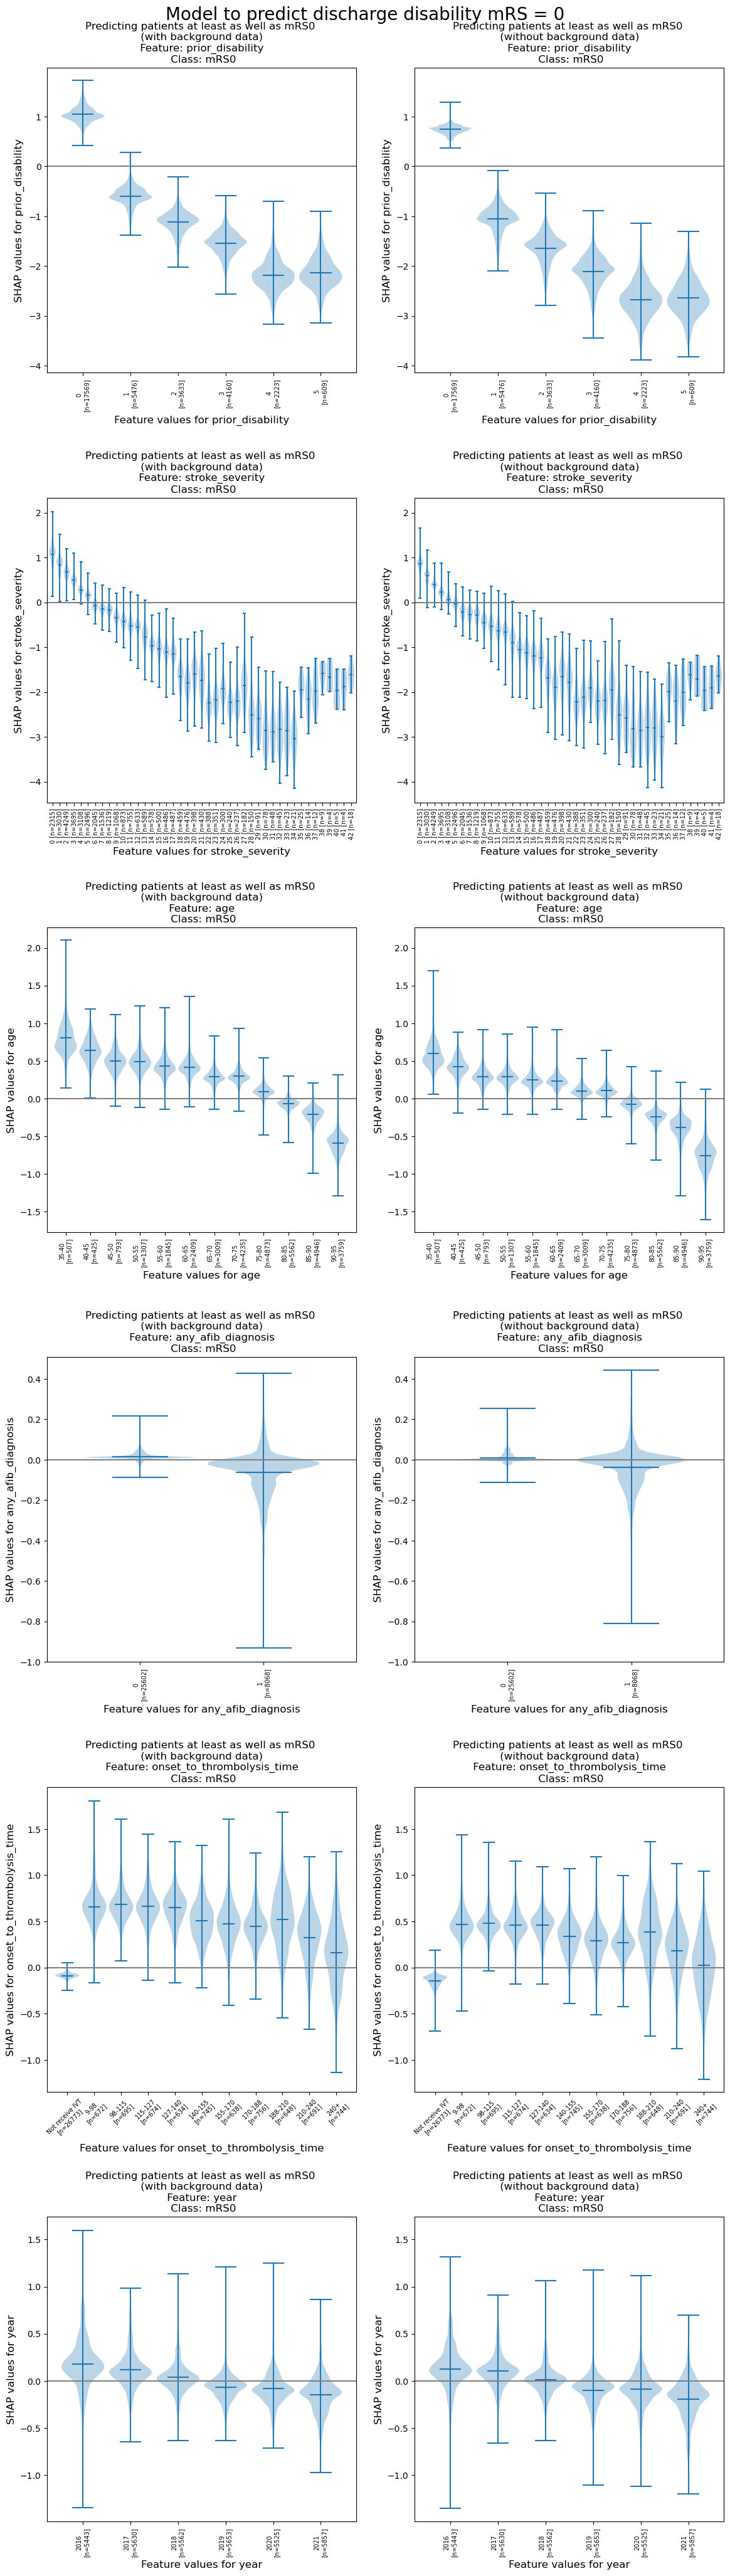

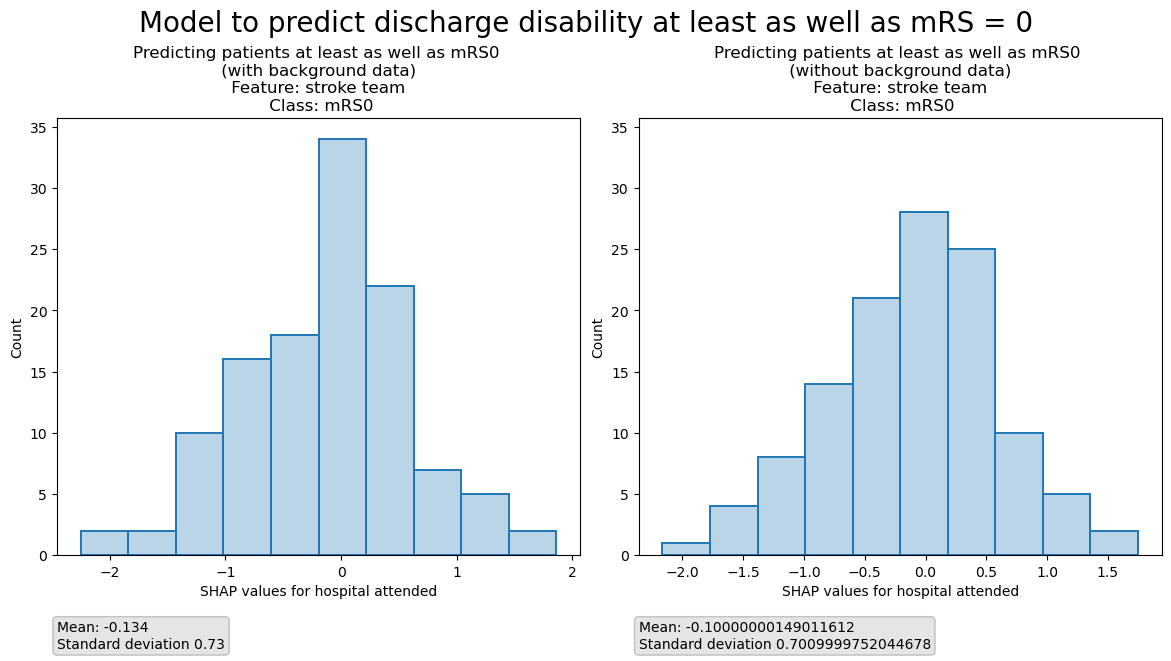

There was a 49.89 fold difference in odds of being classified as mRS0 between hospitals


()

In [46]:
# Violin plots of feature data vs SHAP values
violin_plots_compare_models(binary_threshold,
                            list_model_features_wo_teams, 
                            list_shap_values_extended,
                            list_model_title,
                            equal_steps=False)

# Histogram of stroke team SHAP values
histograms_compare_models(binary_threshold,
                          list_unique_team_feature_names,
                          list_shap_values_extended,
                          list_model_title)